### Summary of the code written below:


##### 1. 4 Compartments have been set up back to back with each Compartment having a SpikeGen and SynChan (having a Simple SynHandler). 
##### 2. A function get__hhsyn_comp() was defined to create a prototype compartment which was saved to '/library' and then an object proto was created by calling the function and then a loop was used to create four compartments by using the copy function and connections between the spikegen and the synh was set up in the loop.<br> A list(comps) was used and it was appended with the compartment created through each iteration.

##### 3. Each compartment has HHChannels as well.
##### 4. A PulseGen was set up and connected to the element at the 0th index of the list.

#### Issue:
    
##### 1. Measuring the membrane potential of the compartments (note that a list for tables was set up as well and the table at index n was connected to the compartment of index n in the comps list): <br><br>  When the synh.synapse[0].weight is set to 1, the spikes die out in the compartments at index 2 and 3 (as the spikes in compartment at index 1 are below the spikegen threshold value which is by default set to 0) but when synh.synapse[0].weight=0.2, the spikes induce action potentials that gets carried forwards to the next compartments. <br><br> The decrease in synh.synapse[0].weight should be decreasing the synaptic strength and hence decreasing the magniude of the EPSP but the opposite is happening.

In [1]:
import moose
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sim=moose.Neutral('/sim')
model=moose.Neutral('/sim/model')
data=moose.Neutral('/sim/data')

In [3]:
erest=-70e-3
ena=115e-3+erest
ek=-12e-3+erest
dia=30e-6
sarea=np.pi*np.power(dia,2)

In [4]:
def get_hhsyn_comp():
    lib=moose.Neutral(f'{sim.path}/library')
    comp_path=f'{lib.path}/comp'
    if moose.exists(comp_path):
        return moose.element(comp_path)

    # The above code returns a compartment object if it has already been created

    # Now, we will create the compartment object
    comp=moose.Compartment(comp_path)
    Cm_spec=1e-2
    Gm_spec=3
    comp.Rm=1/(Gm_spec*sarea)
    comp.Cm=Cm_spec*sarea
    comp.initVm=erest
    comp.Em=-59.89e-3
    comp.Ra=1/(Gm_spec*sarea)

    # Setting up the HHChannels and their properties

    nachan=moose.HHChannel(f'{comp.path}/Na')
    kchan=moose.HHChannel(f'{comp.path}/K')
    moose.connect(nachan,'channel',comp,'channel')
    moose.connect(kchan,'channel',comp,'channel')
    
    nachan.Ek=115e-3+erest
    kchan.Ek=-12e-3+erest
    nachan.Gbar=120*10*sarea
    kchan.Gbar=36*10*sarea

    kchan.Xpower=4
    nachan.Xpower=3
    nachan.Ypower=1

    # Now we will set up the gates 

    n_gate=moose.HHGate(f'{kchan.path}/gateX')
    m_gate=moose.HHGate(f'{nachan.path}/gateX')
    h_gate=moose.HHGate(f'{nachan.path}/gateY')

    vmin=-100e-3
    vmax=100e-3
    vdivs=1000
    v=np.linspace(vmin,vmax,vdivs)

    # Expressions for the alpha and beta values

    m_gate_alphaExpr = 1e3 * 0.1 * (25 - 1e3 * (v - (erest)))/(np.exp((25 - 1e3 * (v - (erest)))/10) - 1)
    m_gate_betaExpr =  1e3 * 4 * np.exp(- 1e3 * (v - (erest))/ 18)
    h_gate_alphaExpr = 1e3 * 0.07 * np.exp(- 1e3 * (v - (erest))/ 20)
    h_gate_betaExpr = 1e3 / (np.exp((30 - 1e3 * (v - (erest))) / 10) + 1)
    n_gate_alphaExpr = 1e3 * 0.01 * (10 - 1e3 * (v - (erest))) / (np.exp((10 - 1e3 * (v - (erest)))/10) - 1)
    n_gate_betaExpr = 1e3 * 0.125 * np.exp(-1e3 * (v - (erest)) / 80)

    # Now, using interpolation we will calculate the values of alpha and beta at different voltages
    # in a given range
    n_gate.tableA=n_gate_alphaExpr
    n_gate.tableB=n_gate_alphaExpr + n_gate_betaExpr
    m_gate.tableA=m_gate_alphaExpr
    m_gate.tableB=m_gate_alphaExpr + m_gate_betaExpr
    h_gate.tableA=h_gate_alphaExpr 
    h_gate.tableB=h_gate_alphaExpr + h_gate_betaExpr

    n_gate.min,n_gate.max,n_gate.divs=vmin,vmax,vdivs
    m_gate.min,m_gate.max,m_gate.divs=vmin,vmax,vdivs
    h_gate.min,h_gate.max,h_gate.divs=vmin,vmax,vdivs
    
    n_gate.useInterpolation=True
    m_gate.useInterpolation=True
    h_gate.useInterpolation=True

    # We have set up the gates and have interpolated values of alpha and beta at the 1000 v steps given by the np.linspace

    # Now, we need to set up the synapse for each neuron,
    # Note: 1. The first neuron will be receiving injected current and will not need to use a synhandler or synchan.
    #       2. The connections between the synhandler and the spikegen will be made through a for loop

    spikegen=moose.SpikeGen(f'{comp.path}/spike')
    moose.connect(comp,'VmOut',spikegen,'Vm')

    synchan=moose.SynChan(f'{comp.path}/synchan')
    moose.connect(synchan,'channel',comp,'channel')

    synh=moose.SimpleSynHandler(f'{synchan.path}/synh')
    moose.connect(synh,'activationOut',synchan,'activation')

    synh.numSynapses=1
    synchan.Gbar=1e-7
    synchan.Ek=0.0
    synchan.tau1=1e-3
    synchan.tau2=5e-3

    synh.synapse[0].weight=1
    synh.synapse[0].delay=1e-3
    
    return comp

In [5]:
proto=get_hhsyn_comp()

In [6]:
# Now, we create 10 such objects using a for loop and store them in lists. 
comps=[]
tabs=[]
synchan_gk=[]
ncomps=4
for ii in range(ncomps):
    comp_hold=moose.copy(proto,model,f'nrn_{ii}')
    if len(comps)>0:
        moose.connect(moose.element(f'{comps[-1].path}/spike'),'spikeOut',moose.element(f'{comp_hold.path}/synchan/synh').synapse[0],'addSpike')

    comps.append(comp_hold)

    vm_tab=moose.Table(f'{data.path}/vm_tab_{ii}')
    moose.connect(vm_tab,'requestOut',comp_hold,'getVm')
    tabs.append(vm_tab)

    gk_tab=moose.Table(f'{data.path}/syn_gk_tab_{ii}')
    moose.connect(gk_tab,'requestOut',moose.element(f'{comps[ii].path}/synchan'),'getGk')
    synchan_gk.append(gk_tab)

In [7]:
# setting up a pulse generator
pulse=moose.PulseGen(f'{model.path}/pulse')
moose.connect(pulse,'output',comps[0],'injectMsg')

<moose.SingleMsg id=5 dataIndex=48 path=/Msgs[0]/singleMsg[48]>

In [8]:
# setting the parameters of the pulse generator
pulse.delay[0]=50e-3
pulse.width[0]=200e-3
pulse.level[0]=1e-9

In [9]:
runtime=300e-3
moose.reinit()
moose.start(runtime)

In [10]:
t=np.arange(len(tabs[1].vector))*tabs[0].dt*1e3

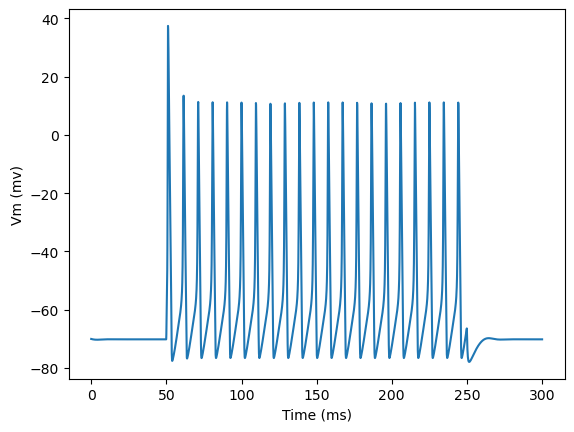

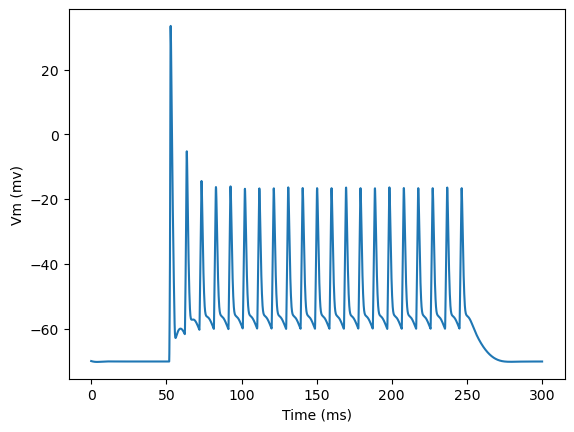

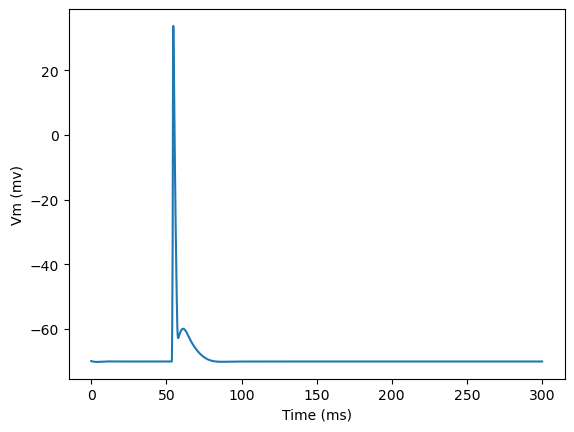

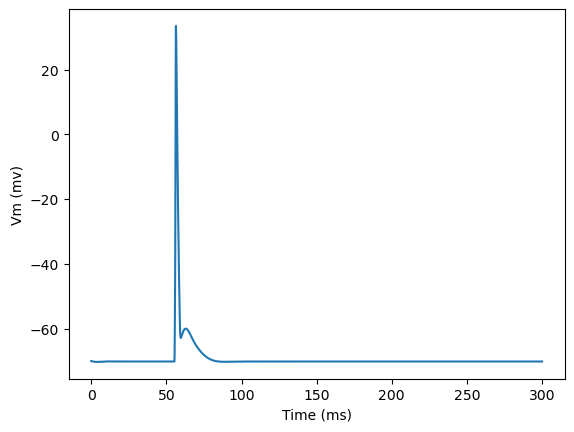

In [11]:
for i in range(len(tabs)):
    plt.plot(t,tabs[i].vector*1e3,label='Membrane potential')
    plt.xlabel('Time (ms)')
    plt.ylabel('Vm (mv)')
    plt.show()

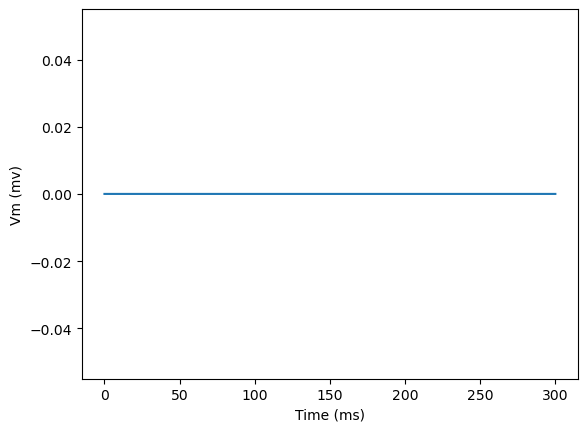

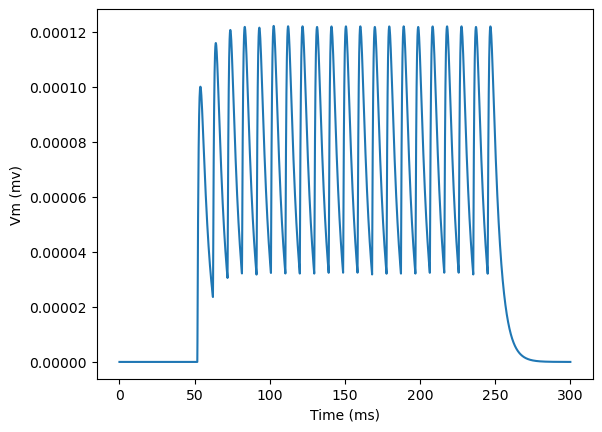

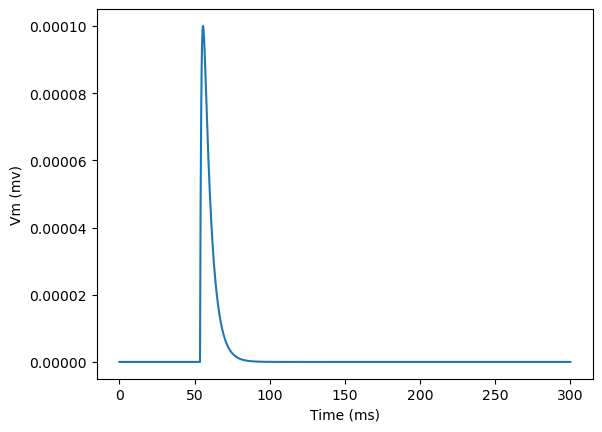

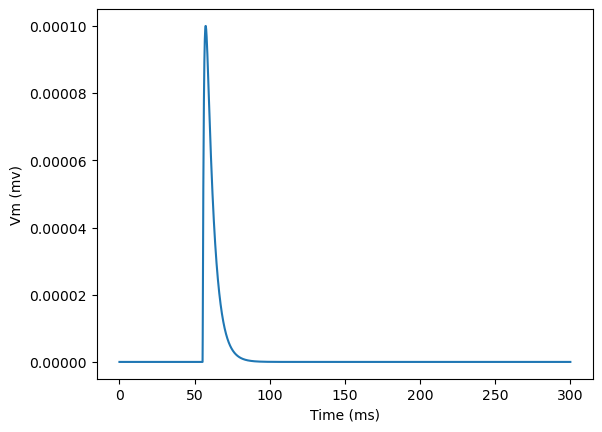

In [12]:
for i in range(len(tabs)):
    plt.plot(t,synchan_gk[i].vector*1e3,label='Membrane potential')
    plt.xlabel('Time (ms)')
    plt.ylabel('Vm (mv)')
    plt.show()